I would like to understand the relationship between dark photon decay length, boost, and lepton displacement. Larger bound state masses increase dark photon boost, which in turn increases dark photon decay length (increasing lepton displacement) and decreases the angular separation between daughter leptons (decreasing lepton displacement). It would be good to generate a quantitative understanding of the combined effect of these two factors. 

I expect such a study to be a useful input to ongoing studies of the efficiency and resolution with which lepton jets reconstruct dark photon decays as well as first step in the study of how best (or whether) to explicitly require that our signal region lepton jets are displaced.

In [1]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
import awkward as ak
from dask.distributed import Client
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from sidm.tools import ffschema, sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(ffschema)
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline

Start by plotting the relevant quantities with a single signal sample and no LJ selections applied

In [2]:
samples = [
    "2Mu2E_200GeV_1p2GeV_24mm",
]
fileset = utilities.make_fileset(samples, "ffntuple_v4")

runner = processor.Runner(
    #executor=processor.IterativeExecutor(),
    executor=processor.FuturesExecutor(),
    schema=ffschema.FFSchema,
    #maxchunks=1,
)

channels = ["baseNoLj"]
p = sidm_processor.SidmProcessor(
    channels,
    ["base_plus_gen"]
)

output = runner.run(fileset, treename="ffNtuplizer/ffNtuple", processor_instance=p)
hists = output["out"][samples[0]]["hists"]

Output()

Output()

Take a look at gen-level dark photon lxy and pt

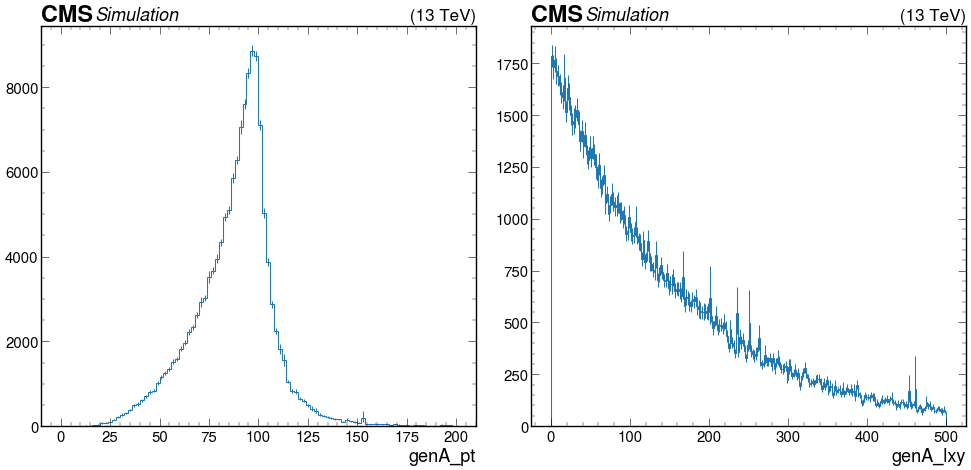

In [3]:
plt.subplots(1, 2, figsize=(20, 10))
plt.subplot(1, 2, 1)
utilities.plot(hists["genA_pt"][channels[0], :])
plt.subplot(1, 2, 2)
utilities.plot(hists["genA_pt_lxy"].project("genA_lxy"))
plt.tight_layout()

Cool, all looks reasonable. Next look at correlation between dark photon pT and lxy with 2D hist and profiles.

/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in divide
  counts = sumw / scale


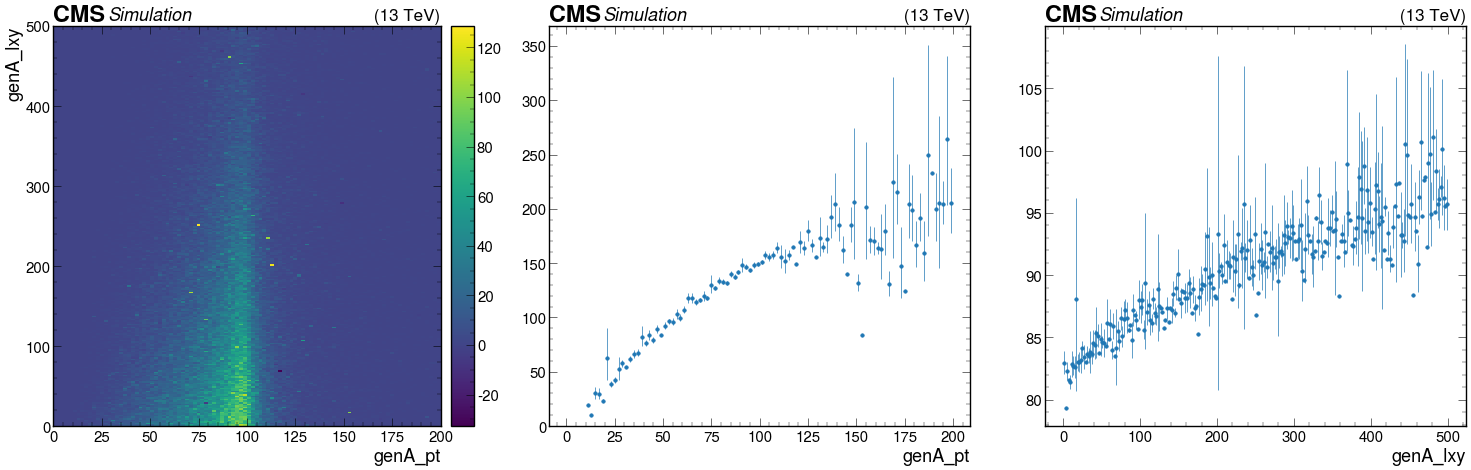

In [4]:
plt.subplots(1, 3, figsize=(30, 10))
plt.subplot(1, 3, 1)
utilities.plot(hists["genA_pt_lxy"][channels[0], :, :])
plt.subplot(1, 3, 2)
utilities.plot(hists["genA_pt_lxy"][channels[0], :, :].profile("genA_lxy"), histtype='errorbar')
plt.subplot(1, 3, 3)
utilities.plot(hists["genA_pt_lxy"][channels[0], :, :].profile("genA_pt"), histtype='errorbar')
plt.tight_layout()

Nice, the expected positive correlation is totally obvious in the profiles. It will be interesting to look at higher-mass samples later to see how things behave above 200GeV in dark photon pT.

Look at lepton displacement next. I expect dR matching will be sufficient to associate gen-level leptons with the correct dark photon, but according to explore_genParticles.ipynb, gen particle d0 isn't stored. I could either look at reco quantities or find a way to calculate or approximate d0 for gen electrons and muons.

Start by looking at reco lepton displacement. It appears that pf and dsa muons have d0 values saved in the ntuples, but electrons do not, so just start with muons for now I guess.

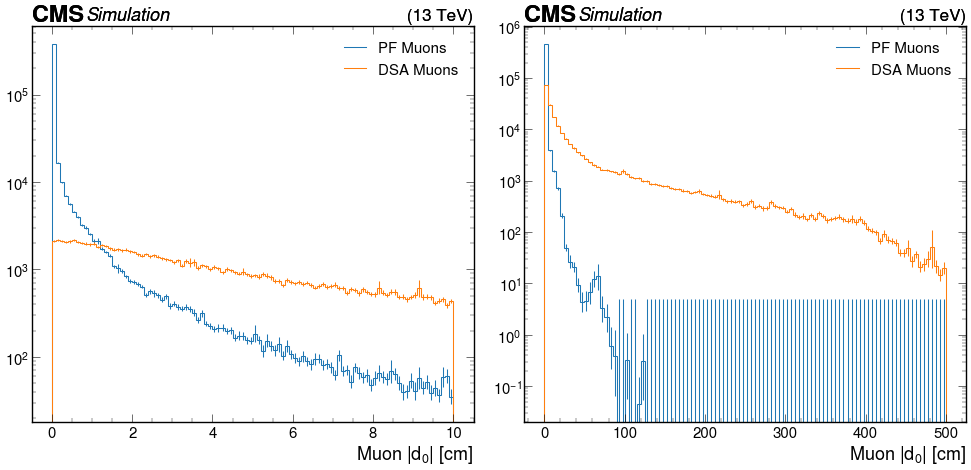

In [5]:
plt.subplots(1, 2, figsize=(20, 10))
plt.subplot(1, 2, 1)
utilities.plot(hists["muon_absD0_lowRange"][channels[0], :])
utilities.plot(hists["dsaMuon_absD0_lowRange"][channels[0], :])
plt.legend(["PF Muons", "DSA Muons"])
plt.yscale('log')
plt.subplot(1, 2, 2)
utilities.plot(hists["muon_absD0"][channels[0], :])
utilities.plot(hists["dsaMuon_absD0"][channels[0], :])
plt.legend(["PF Muons", "DSA Muons"])
plt.yscale('log')
plt.tight_layout()

Generally looks reasonable, but what's up with the peak in PF muons around 70cm? Set that mystery aside for now, and start looking at relationship between muon d0 and lepton jet pT and lxy. Ideally would start by looking at 2D plots of muon d0 vs properties of nearest lepton jet, but I need to fix a technical issue with p4.nearest before I can do that. Start by applying some dark photon and lxy cuts instead.

In [6]:
importlib.reload(sidm_processor)

runner = processor.Runner(
    executor=processor.IterativeExecutor(),
    schema=ffschema.FFSchema,
#    maxchunks=1,
)

channels = [
    "baseNoLj_promptA",
    "baseNoLj_displacedA",
    "baseNoLj_veryDisplacedA",
]
p = sidm_processor.SidmProcessor(
    channels,
    ["base_plus_gen"]
)

output = runner.run(fileset, treename="ffNtuplizer/ffNtuple", processor_instance=p)
hists = output["out"][samples[0]]["hists"]

Output()

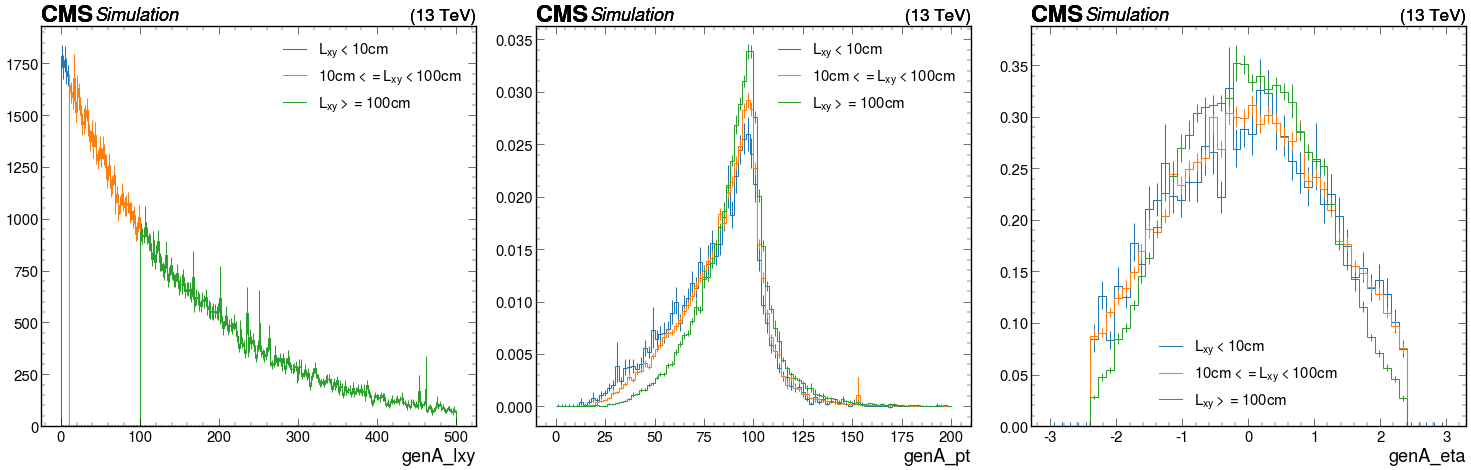

In [7]:
legend = [
    r"$L_{xy} < 10 cm$",
    r"$10 cm <= L_{xy} < 100 cm$",
    r"$L_{xy} >= 100 cm$",
]
plt.subplots(1, 3, figsize=(30, 10))
plt.subplot(1, 3, 1)
for ch in channels:
    utilities.plot(hists["genA_pt_lxy"][ch, :, :].project("genA_lxy"))
plt.legend(legend)
plt.subplot(1, 3, 2)
for ch in channels:
    utilities.plot(hists["genA_pt"][ch, :], density=True)
plt.legend(legend)
plt.subplot(1, 3, 3)
for ch in channels:
    utilities.plot(hists["genA_eta_phi"][ch, :, :].project("genA_eta"), density=True)
plt.legend(legend)
plt.tight_layout()